In [586]:

# Install kaggle and dataset, extract data
"""%matplotlib inline
%pip install kaggle
%pip install pydot
!brew install graphviz
!/Users/jon/Library/Python/3.9/bin/kaggle competitions download -c sf-crime
import shutil
shutil.unpack_archive("sf-crime.zip", "sf-crime")
shutil.unpack_archive("sf-crime/train.csv.zip", "sf-crime/train")
shutil.unpack_archive("sf-crime/test.csv.zip", "sf-crime/test")
shutil.unpack_archive("sf-crime/sampleSubmission.csv.zip", "sf-crime/sampleSubmission")
"""

'%matplotlib inline\n%pip install kaggle\n%pip install pydot\n!brew install graphviz\n!/Users/jon/Library/Python/3.9/bin/kaggle competitions download -c sf-crime\nimport shutil\nshutil.unpack_archive("sf-crime.zip", "sf-crime")\nshutil.unpack_archive("sf-crime/train.csv.zip", "sf-crime/train")\nshutil.unpack_archive("sf-crime/test.csv.zip", "sf-crime/test")\nshutil.unpack_archive("sf-crime/sampleSubmission.csv.zip", "sf-crime/sampleSubmission")\n'

In [587]:
# load csv data from train.csv
import pandas as pd
import re
train = pd.read_csv("sf-crime/train/train.csv")
train.sample(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
581687,2007-02-20 15:53:00,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Tuesday,CENTRAL,NONE,300 Block of PINE ST,-122.401296,37.792118
51249,2014-09-06 07:03:00,SUSPICIOUS OCC,INVESTIGATIVE DETENTION,Saturday,NORTHERN,NONE,HICKORY ST / FRANKLIN ST,-122.421054,37.775694
792307,2004-03-01 14:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,NORTHERN,NONE,GOLDEN GATE AV / FRANKLIN ST,-122.422090,37.780822
103643,2013-12-26 17:45:00,OTHER OFFENSES,CONSPIRACY,Thursday,CENTRAL,"ARREST, BOOKED",300 Block of POST ST,-122.407613,37.788449
258355,2011-11-16 21:58:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Wednesday,NORTHERN,NONE,1300 Block of UNION ST,-122.421518,37.798810


In [588]:
# load csv data from test.csv
test_useless = pd.read_csv("sf-crime/test/test.csv")
test_useless.sample(5)
test_useless["Address"].sample(10)

79736            MADRID ST / BRAZIL AV
701768          800 Block of BRYANT ST
678153      2900 Block of SAN BRUNO AV
717091      1200 Block of HAMPSHIRE ST
875576           1500 Block of 34TH AV
160557            0 Block of WALLER ST
160318           FLORA ST / BAYVIEW ST
71327          100 Block of STEUART ST
460636    700 Block of MOUNT VERNON AV
314382        300 Block of DOUGLASS ST
Name: Address, dtype: object

In [589]:
# convert the category column to a one hot encoded array
y_train = pd.get_dummies(train["Category"])
class_names = y_train.columns
x_train = train.drop(["Category", "Descript", "Resolution"], axis=1)
x_train

,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,Monday,TARAVAL,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,Monday,INGLESIDE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,Monday,SOUTHERN,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,Monday,SOUTHERN,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [590]:
def string_to_int(string):
    return sum([ord(c) for c in string])

# a function that takes an array of unique values and returns a dictionary with values as keys and indices as values
def get_dict(array):
    return {array[i]: i+1 for i in range(len(array))}

def min_max_normalize(array, min=None, max=None):
    if min is None: min = array.min()
    if max is None: max = array.max()
    return (array - min) / (max - min)

def address_get_dummies(data: pd.DataFrame, prefix=None):
    # create a new dataframe
    df = pd.DataFrame()

    # get all the street types
    types = []
    for address in data:
        # get all two chars that are capitalized with regex
        types += [prefix + "_" + match for match in re.findall(r"\b[A-Z]{2}\b", address)]
    types = list(set(types))

    # create a column for each street type
    # and set it to 1 if the address contains that street type
    for street_type in types:
        df[street_type] = data.apply(lambda x: 1.0 if street_type in x else 0.0)

    return df

def preprocess_data(df):
    """
    Preprocesses the data by converting strings to integers without normalization
    """
    # convert date to datetime
    df["Dates"] = pd.to_datetime(df["Dates"], format="%Y-%m-%d %H:%M:%S")
    # add new columns
    df["Year"] = df["Dates"].dt.year
    df["Month"] = df["Dates"].dt.month
    df["Day"] = df["Dates"].dt.day
    df["Hour"] = df["Dates"].dt.hour
    df["Minute"] = df["Dates"].dt.minute
    df["DayOfWeek"] = df["Dates"].dt.dayofweek
    df["WeekOfYear"] = df["Dates"].dt.isocalendar().week
    df = df.drop(["Dates"], axis=1)
    # convert pd district to one-hot encoding
    df = pd.concat([df, pd.get_dummies(df["PdDistrict"], prefix="PdDistrict", dtype=np.float32)], axis=1)
    df = df.drop(["PdDistrict"], axis=1)
    # convert addresses to one-hot encoding
    df = pd.concat([df, address_get_dummies(df["Address"], prefix="Address")], axis=1)
    df = df.drop(["Address"], axis=1)

    return df

def normalize_data(df):
    """
    Normalizes the data
    """
    df = df.copy()

    df["DayOfWeek"] = min_max_normalize(df["DayOfWeek"])
    df["Year"] = min_max_normalize(df["Year"])
    df["Month"] = min_max_normalize(df["Month"])
    df["Day"] = min_max_normalize(df["Day"])
    df["Hour"] = min_max_normalize(df["Hour"], 0, 23)
    df["Minute"] = min_max_normalize(df["Minute"], min=0, max=59)
    df["WeekOfYear"] = min_max_normalize(df["WeekOfYear"])
    
    # map the coordinates to a number by using min max normalization
    df["X"] = min_max_normalize(train["X"], -180, 180)
    df["Y"] = min_max_normalize(train["Y"], -90, 90)

    return df

def convert_df_to_numpy(df):
    """
    Converts the pandas dataframe to a numpy array
    """
    return np.asarray(df).astype(np.float32)

def split_data(x, y, test_size=0.2):
    """
    Splits the data into a training and validation set
    """
    from sklearn.model_selection import train_test_split
    # split the data into a training and validation set
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size, random_state=42)
    # convert the dataframes to numpy arrays
    x_train = convert_df_to_numpy(x_train)
    x_val = convert_df_to_numpy(x_val)
    y_train = convert_df_to_numpy(y_train)
    y_val = convert_df_to_numpy(y_val)
    return x_train, x_val, y_train, y_val

x_train = preprocess_data(x_train)
x_train_ = normalize_data(x_train)

x_train, x_val, y_train, y_val = split_data(x_train_, y_train)

x_train_.sample(20)


,DayOfWeek,X,Y,Year,Month,Day,Hour,Minute,WeekOfYear,PdDistrict_BAYVIEW,...,Address_CR,Address_AL,Address_TR,Address_PL,Address_GG,Address_SF,Address_JR,Address_WK,Address_FE,Address_MT
812181,0.666667,0.159969,0.709896,0.000000,0.909091,0.433333,0.913043,0.000000,0.88,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140505,1.000000,0.159914,0.709901,0.833333,0.454545,0.966667,0.826087,0.711864,0.48,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674278,0.500000,0.159967,0.709728,0.166667,0.818182,0.633333,0.782609,0.000000,0.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
739559,0.500000,0.159871,0.709560,0.083333,0.909091,0.333333,0.391304,0.508475,0.88,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
577000,0.000000,0.159991,0.709863,0.333333,0.181818,0.600000,0.652174,0.627119,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144945,0.500000,0.159976,0.709867,0.833333,0.454545,0.400000,0.086957,0.000000,0.44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
842644,0.166667,0.160029,0.709608,0.000000,0.454545,0.766667,0.391304,0.593220,0.48,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
837881,1.000000,0.159965,0.709719,0.000000,0.545455,0.400000,0.043478,0.813559,0.52,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
618943,1.000000,0.159911,0.709889,0.250000,0.545455,0.966667,0.652174,0.016949,0.56,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388427,0.500000,0.159933,0.709793,0.500000,0.909091,0.833333,0.913043,0.508475,0.92,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [591]:
# here we import everything you need to build the CNN
import keras
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import UpSampling2D, Input, BatchNormalization, Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation, RandomZoom
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
import tensorflow as tf
import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


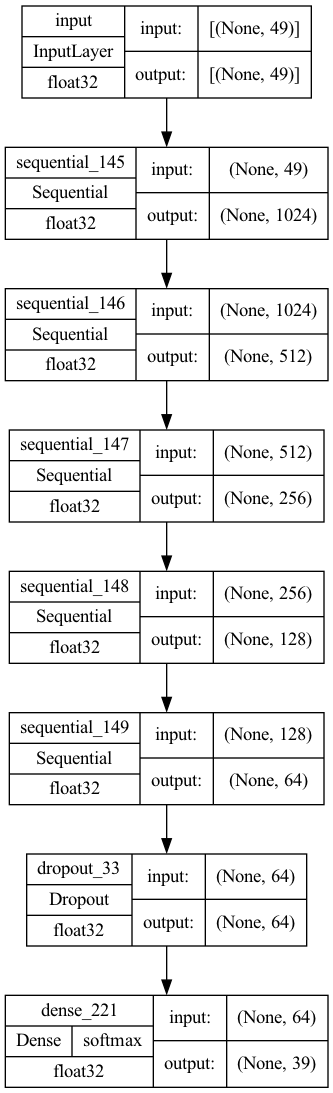

In [592]:
def plot_learning_curves(history):
    n = len(history.history['loss'])
    plt.plot(np.arange(1, n+1), history.history['loss'], label="training loss")
    plt.plot(np.arange(1, n+1), history.history['val_loss'], label="validation loss")
    plt.legend()
    plt.grid()
    plt.xticks(np.arange(1, n+1, 2))


def DenseReluBatchNorm(units: int, activation: str = "relu", use_bias: bool = True):
    return keras.Sequential(
        [
            Dense(units, use_bias=use_bias),
            Activation(activation),
            BatchNormalization(),
        ]
    )

model = Sequential()

model.add(Input(shape=(x_train.shape[1],), name='input'))

model.add(DenseReluBatchNorm(1024, activation='relu'))
model.add(DenseReluBatchNorm(512, activation='relu'))
model.add(DenseReluBatchNorm(256, activation='relu'))
model.add(DenseReluBatchNorm(128, activation='relu'))
model.add(DenseReluBatchNorm(64, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(units=y_train.shape[1], activation='softmax'))  # we need to classify the category of the crime

tf.keras.utils.plot_model(model, to_file="/tmp/model.png", show_layer_activations=True, show_shapes=True, show_dtype=True, show_layer_names=True)


In [593]:
model.summary()

Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_145 (Sequential)  (None, 1024)             55296     
                                                                 
 sequential_146 (Sequential)  (None, 512)              526848    
                                                                 
 sequential_147 (Sequential)  (None, 256)              132352    
                                                                 
 sequential_148 (Sequential)  (None, 128)              33408     
                                                                 
 sequential_149 (Sequential)  (None, 64)               8512      
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_221 (Dense)           (None, 39)             

In [595]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=1,
)

history = model.fit(
  x_train,
  y_train,
  epochs=30,
  batch_size=32,
  validation_split=.1,
  callbacks=[early_stopping],
)

Epoch 1/30


2022-12-07 11:42:59.488620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19757/19757 [==============================] - ETA: 0s - loss: 2.5702 - accuracy: 0.2367

2022-12-07 11:50:20.400424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19757/19757 [==============================] - 462s 23ms/step - loss: 2.5702 - accuracy: 0.2367 - val_loss: 2.5014 - val_accuracy: 0.2541
Epoch 2/30
19757/19757 [==============================] - 457s 23ms/step - loss: 2.5155 - accuracy: 0.2473 - val_loss: 2.4918 - val_accuracy: 0.2536
Epoch 3/30
19757/19757 [==============================] - 473s 24ms/step - loss: 2.5034 - accuracy: 0.2505 - val_loss: 2.4784 - val_accuracy: 0.2580
Epoch 4/30
19757/19757 [==============================] - 487s 25ms/step - loss: 2.4963 - accuracy: 0.2521 - val_loss: 2.4729 - val_accuracy: 0.2595
Epoch 5/30
19757/19757 [==============================] - 471s 24ms/step - loss: 2.4918 - accuracy: 0.2533 - val_loss: 2.4693 - val_accuracy: 0.2608
Epoch 6/30
19757/19757 [==============================] - 467s 24ms/step - loss: 2.4883 - accuracy: 0.2541 - val_loss: 2.4706 - val_accuracy: 0.2591


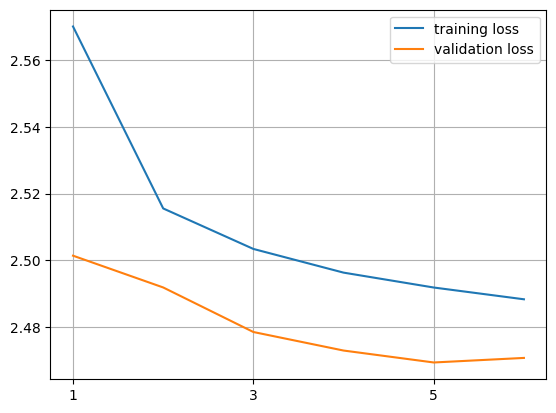

In [596]:
plot_learning_curves(history)

In [606]:
from sklearn.metrics import classification_report

predicted_class_probabilities = model.predict(x_val)
predicted_labels = np.argmax(predicted_class_probabilities, axis=1)

# convert predicated_labels to one-hot encoding
predicted_labels = keras.utils.to_categorical(predicted_labels, num_classes=predicted_class_probabilities.shape[1])

print(classification_report(y_true=y_val, y_pred=predicted_labels, target_names=class_names))


5488/5488 [==============================] - 21s 4ms/step
                             precision    recall  f1-score   support

                      ARSON       0.00      0.00      0.00       321
                    ASSAULT       0.20      0.02      0.03     15364
                 BAD CHECKS       0.00      0.00      0.00        72
                    BRIBERY       0.00      0.00      0.00        58
                   BURGLARY       0.00      0.00      0.00      7389
         DISORDERLY CONDUCT       0.22      0.10      0.13       828
DRIVING UNDER THE INFLUENCE       0.00      0.00      0.00       459
              DRUG/NARCOTIC       0.29      0.26      0.28     10723
                DRUNKENNESS       0.00      0.00      0.00       857
               EMBEZZLEMENT       0.00      0.00      0.00       222
                  EXTORTION       0.00      0.00      0.00        51
            FAMILY OFFENSES       0.00      0.00      0.00        92
     FORGERY/COUNTERFEITING       0.17      

/Users/jon/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


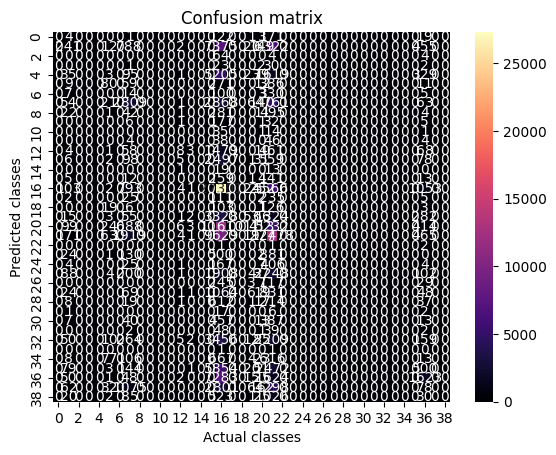

In [605]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_val.argmax(axis=1), predicted_labels.argmax(axis=1)), annot=True, fmt='d', cmap='magma').set(
    xlabel="Actual classes", ylabel="Predicted classes", title='Confusion matrix')
plt.show()


In [604]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets
